In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys
import logging


# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Graph
import networkx as nx
import tensorflow_gnn as tfgnn
from pyvis.network import Network
import webbrowser

# Tensorflow
import tensorflow as tf


2025-06-06 10:07:33.300936: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 10:07:33.349429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 10:07:33.623096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-06 10:07:33.623176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-06 10:07:33.624593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 1. Load Data

In [3]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'data_cpv.csv'))

In [4]:
data.head()

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,origineFrance,lieuExecution_code,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5
0,210601209000132022_M013,2022_M013,Marché,21060120900013,COMMUNE DE SAINT ETIENNE DE TINEE,210601209.0,38177692100029,SIRET,SERMATECH,381776921.0,...,NaN,06660,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de bâtiments,45000000,45200000,45210000,45210000
1,217100759000182024RENOCHARP,2024RENOCHARP,Marché,21710075900018,COMMUNE DE CHALMOUX,217100759.0,75203574100038,SIRET,MACON ETANCHEITE,752035741.0,...,0.0,71140,Code postal,NaN,data.gouv.fr decp-2025-01.json,Travaux de charpente et de couverture et trava...,45000000,45200000,45260000,45261000
2,200066231000162022033INFOL00,2022033INFOL00,Marché,20006623100016,CC DES PORTES D'ARIEGE PYRENEES,200066231.0,49459697600014,SIRET,EQUADEX,494596976.0,...,NaN,09100,Code postal,2022033INFOL00,data.gouv.fr decp-2024.json,Services de gestion d'installations pour le dé...,72000000,72500000,72510000,72514000
3,243100518001702024M05,2024M05,Marché,24310051800170,TOULOUSE METROPOLE,243100518.0,59278023300017,SIRET,RIVES & EAUX DU SUD-OUEST,592780233.0,...,0.0,31000,Code postal,NaN,data.gouv.fr decp-2025-04.json,Services d'ingénierie,71000000,71300000,71300000,71300000
4,21590544900017202402401,202402401,Marché,21590544900017,COMMUNE DE SAINT SAULVE,215905449.0,32683156700010,SIRET,ALTOMARE ALTALU,326831567.0,...,NaN,59800,Code postal,NaN,data.gouv.fr decp-2024.json,Serrurerie,44000000,44300000,44310000,44316000


# 2. Preprocess

In [5]:
X = data[['montant', 'acheteur_nom', 'titulaire_nom', 
          'procedure', 'dureeMois', 'formePrix', 'attributionAvance',
          'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance','codeCPV_3']]


In [6]:
cpv_3 = data['codeCPV_3'].value_counts()
cpv_3_list = cpv_3[cpv_3 > 200].reset_index()['codeCPV_3']

X = X[X['codeCPV_3'].isin(cpv_3_list)]

X = X[~X['dureeMois'].isna()].copy()

In [7]:
X.head()

,montant,acheteur_nom,titulaire_nom,procedure,dureeMois,formePrix,attributionAvance,sousTraitanceDeclaree,typeGroupementOperateurs,tauxAvance,codeCPV_3
0,154924.27,COMMUNE DE SAINT ETIENNE DE TINEE,SERMATECH,Procédure adaptée,8.0,Mixte,NaN,NaN,Pas de groupement,NaN,45200000
1,94920.00,COMMUNE DE CHALMOUX,MACON ETANCHEITE,Procédure adaptée,18.0,Unitaire,NaN,1.0,Pas de groupement,0.0,45200000
2,350000.00,CC DES PORTES D'ARIEGE PYRENEES,EQUADEX,Appel d'offres ouvert,48.0,Mixte,NaN,NaN,Pas de groupement,NaN,72500000
3,1100000.00,TOULOUSE METROPOLE,RIVES & EAUX DU SUD-OUEST,Appel d'offres ouvert,48.0,Mixte,1.0,1.0,Solidaire,0.1,71300000
4,40770.00,COMMUNE DE SAINT SAULVE,ALTOMARE ALTALU,Procédure adaptée,5.0,Forfaitaire,NaN,NaN,Pas de groupement,NaN,44300000


In [8]:
def _calculate_node_features(entity_data: pd.DataFrame,
                               partner_col: str):
        """Calculate features for a node (buyer or supplier)."""
        n_partners = entity_data[partner_col].nunique()
        contracts_per_partner = len(entity_data) / n_partners \
            if n_partners > 0 else 0
            
        # Calculate contracts per partner distribution
        partner_contract_counts = entity_data[partner_col].value_counts()
        max_contracts_per_partner = partner_contract_counts.max() if not partner_contract_counts.empty else 0
        min_contracts_per_partner = partner_contract_counts.min() if not partner_contract_counts.empty else 0
        std_contracts_per_partner = partner_contract_counts.std() if len(partner_contract_counts) > 1 else 0
            
        features = [
            len(entity_data),  # Number of contracts
            entity_data['montant'].sum(),  # Total amount
            # entity_data['montant'].mean(),  # Average amount
            # entity_data['montant'].std() if len(entity_data) > 1 else 0,
            # n_partners,  # Number of unique partners
            # entity_data['montant'].max(),  # Maximum contract amount
            # entity_data['montant'].min(),  # Minimum contract amount
            # contracts_per_partner,  # Average contracts per partner
            # max_contracts_per_partner,  # Maximum contracts with any single partner
            # min_contracts_per_partner,  # Minimum contracts with any single partner
            # std_contracts_per_partner  # Standard deviation of contracts per partner
        ]
        return features


def create_graph(df: pd.DataFrame):
    """Transform procurement data into a graph structure."""
    logger.info("Creating graph structure...")
    
    # Create unique identifiers for buyers and suppliers
    buyers = df['acheteur_nom'].unique()
    suppliers = df['titulaire_nom'].unique()
    
    # Create node mappings
    buyer_to_id = {buyer: i for i, buyer in enumerate(buyers)}
    supplier_to_id = {supplier: i + len(buyers)
                        for i, supplier in enumerate(suppliers)}
    
    # Combine all nodes
    all_nodes = list(buyers) + list(suppliers)


    print("Creating edges...")
    
    # Create edges (contracts) and edge features
    edges = []
    edge_features = []
    
    for _, row in df.iterrows():
        buyer_id = buyer_to_id[row['acheteur_nom']]
        supplier_id = supplier_to_id[row['titulaire_nom']]
        
        edges.append([buyer_id, supplier_id])
        
        # Edge features: contract information
        cpv_hash = hash(str(row.get('codeCPV_3', ''))) % 1000
        proc_hash = hash(str(row.get('procedure', ''))) % 100
        duree = row.get('dureeMois', 0) \
            if pd.notna(row.get('dureeMois')) else 0
        
        edge_features.append([
            np.log1p(row['montant']),  # Log-transformed amount
            cpv_hash,  # CPV category
            proc_hash,  # Procedure type
            duree
        ])
    

    # Create node features
    node_features = []
    node_types = []  # 0 for buyers, 1 for suppliers
    

    print("Creating buyer features...")
    # Buyer features
    for buyer in buyers:
        buyer_data = df[df['acheteur_nom'] == buyer]
        features = _calculate_node_features(buyer_data,
                                                'titulaire_nom')
        node_features.append(features)
        node_types.append(0)  # Buyer
    

    print("Creating supplier features...")
    # Supplier features
    for supplier in suppliers:
        supplier_data = df[df['titulaire_nom'] == supplier]
        features = _calculate_node_features(supplier_data,
                                                'acheteur_nom')
        node_features.append(features)
        node_types.append(1)  # Supplier
    
    return {
        'nodes': all_nodes,
        'edges': np.array(edges),
        'node_features': np.array(node_features, dtype=np.float32),
        'edge_features': np.array(edge_features, dtype=np.float32),
        'node_types': np.array(node_types),
        'buyer_to_id': buyer_to_id,
        'supplier_to_id': supplier_to_id
            }




In [9]:
X_500 = X.copy().head(500)

X_graph = create_graph(X_500)
X_graph

INFO:__main__:Creating graph structure...


Creating edges...
Creating buyer features...
Creating supplier features...


{'nodes': ['COMMUNE DE SAINT ETIENNE DE TINEE',
  'COMMUNE DE CHALMOUX',
  "CC DES PORTES D'ARIEGE PYRENEES",
  'TOULOUSE METROPOLE',
  'COMMUNE DE SAINT SAULVE',
  'COMMUNE DE PIERRELATTE',
  'CA MONTELIMAR-AGGLOMERATION',
  'ORLEANS METROPOLE',
  'COMMUNE DE LA GARNACHE',
  'DEPARTEMENT DE LA CHARENTE',
  "COMMUNAUTE D'AGGLOMERATION LA ROCHELLE",
  'COMMUNE DE BERGERAC',
  'COMMUNE DE ELBEUF',
  'METROPOLE GRENOBLE-ALPES-METROPOLE (METRO)',
  'COMMUNE DE HARNES',
  'COMMUNE DE PONT-SAINT-ESPRIT',
  'COMMUNAUTE URBAINE DU GRAND REIMS',
  "COMMUNAUTE D'AGGLOMERATION DU PUY-EN-VELAY",
  'HABITAT DU GARD',
  'COMMUNE DE BEAULIEU SUR MER',
  'COMMUNE DE SAINT MARTIN LA GARENNE',
  'COMMUNE DE VILLEPARISIS',
  'COMMUNE DE CUSSET',
  'COMMUNE DE CRILLON LE BRAVE',
  'COMMUNE DE TARNOS',
  'COMMUNE DE CHATEAU-RENAULT',
  'ASA ASSAINISSEMENTDE LA BASSE PLAINE',
  'COMMUNE DE SAINT MALO',
  'PARIS HABITAT-OPH',
  "SYNDICAT AUDOIS D'ENERGIES ET DU NUMERIQUE SYADEN",
  'COMMUNE DE BOURRET',
  'C

In [10]:
def visualize_procurement_graph(graph_data, title: str = "Procurement Network"):
    """Create an interactive visualization of the full procurement graph.
    
    Args:
        graph_data: Dictionary containing the graph data from create_graph
        title: Title for the visualization
    """
    
# Create a new network
    net = Network(height="900px", width="100%", bgcolor="#ffffff",
                font_color="black", notebook=False)
    
    # Add nodes
    for i, (name, node_type) in enumerate(zip(
        graph_data['nodes'], graph_data['node_types'])):
        
        # Calculate node size based on number of contracts
        num_contracts = int(graph_data['node_features'][i][0])
        node_size = min(50 + num_contracts * 2, 100)  # Scale size but cap it
        
        # Calculate node color based on total amount
        total_amount = float(graph_data['node_features'][i][1])
        # Normalize amount to a color scale (blue to red)
        amount_ratio = min(total_amount / 1e6, 1.0)  # Cap at 1M
        color = f"rgb({int(255 * amount_ratio)}, 0, {int(255 * (1 - amount_ratio))})"
        
        # Add node with properties
        net.add_node(
            int(i),  # Convert to Python int
            label=str(name),  # Convert to Python string
            title=f"Type: {'Buyer' if node_type == 0 else 'Supplier'}\n"
                    f"Contracts: {num_contracts}\n"
                    f"Total Amount: {total_amount:,.2f}\n",
                    #f"Avg Amount: {float(graph_data['node_features'][i][2]):,.2f}\n"
                    #f"Partners: {int(graph_data['node_features'][i][4])}",
            color=color,
            size=node_size,
            shape="diamond" if node_type == 0 else "dot"
        )
    
    # Add edges with weights based on contract amounts
    for i, edge in enumerate(graph_data['edges']):
        # Get edge features
        edge_features = graph_data['edge_features'][i]
        contract_amount = float(np.exp(edge_features[0]))  # Convert back from log
        
        # Scale edge width based on contract amount
        edge_width = min(1 + contract_amount / 1e5, 5)  # Scale but cap at 5
        
        net.add_edge(
            int(edge[0]),  # Convert to Python int
            int(edge[1]),  # Convert to Python int
            width=edge_width,
            title=f"Amount: {contract_amount:,.2f}"
        )
    
    # Configure physics layout for initial spreading, then disable for static view
    net.set_options("""
        {
            "physics": {
                "forceAtlas2Based": {
                    "gravitationalConstant": -50,
                    "centralGravity": 0.01,
                    "springLength": 200,
                    "springConstant": 0.08,
                    "damping": 0.9,  // Higher damping for faster settling
                    "avoidOverlap": 1
                },
                "maxVelocity": 50,
                "solver": "forceAtlas2Based",
                "timestep": 0.35,
                "stabilization": {
                    "enabled": true,
                    "iterations": 300,  // Lower for faster stop
                    "updateInterval": 25
                }
            },
            "interaction": {
                "hover": true,
                "tooltipDelay": 200,
                "hideEdgesOnDrag": true,
                "navigationButtons": true
            }
        }
        """)
    #net.toggle_physics(False)
    
    # Add title
    #net.set_title(title)
    
    # Save and open in browser from the data folder
    data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
    os.makedirs(data_dir, exist_ok=True)
    output_path = os.path.join(data_dir, 'procurement_graph.html')
    net.save_graph(output_path)
    webbrowser.open('file://' + output_path)

In [11]:
X_graph

{'nodes': ['COMMUNE DE SAINT ETIENNE DE TINEE',
  'COMMUNE DE CHALMOUX',
  "CC DES PORTES D'ARIEGE PYRENEES",
  'TOULOUSE METROPOLE',
  'COMMUNE DE SAINT SAULVE',
  'COMMUNE DE PIERRELATTE',
  'CA MONTELIMAR-AGGLOMERATION',
  'ORLEANS METROPOLE',
  'COMMUNE DE LA GARNACHE',
  'DEPARTEMENT DE LA CHARENTE',
  "COMMUNAUTE D'AGGLOMERATION LA ROCHELLE",
  'COMMUNE DE BERGERAC',
  'COMMUNE DE ELBEUF',
  'METROPOLE GRENOBLE-ALPES-METROPOLE (METRO)',
  'COMMUNE DE HARNES',
  'COMMUNE DE PONT-SAINT-ESPRIT',
  'COMMUNAUTE URBAINE DU GRAND REIMS',
  "COMMUNAUTE D'AGGLOMERATION DU PUY-EN-VELAY",
  'HABITAT DU GARD',
  'COMMUNE DE BEAULIEU SUR MER',
  'COMMUNE DE SAINT MARTIN LA GARENNE',
  'COMMUNE DE VILLEPARISIS',
  'COMMUNE DE CUSSET',
  'COMMUNE DE CRILLON LE BRAVE',
  'COMMUNE DE TARNOS',
  'COMMUNE DE CHATEAU-RENAULT',
  'ASA ASSAINISSEMENTDE LA BASSE PLAINE',
  'COMMUNE DE SAINT MALO',
  'PARIS HABITAT-OPH',
  "SYNDICAT AUDOIS D'ENERGIES ET DU NUMERIQUE SYADEN",
  'COMMUNE DE BOURRET',
  'C

In [12]:
graph_data = X_graph

node_features_scaled = graph_data['node_features']
edge_features_scaled = graph_data['edge_features']

In [13]:
def create_tensorflow_graph(graph_data,
                                node_features_scaled: np.ndarray,
                                edge_features_scaled: np.ndarray
                                ) -> tfgnn.GraphTensor:
    """Create a TensorFlow GNN graph from our data."""
    logger.info("Creating TensorFlow GNN graph...")
        
    # Create the graph tensor with single node set
    graph_tensor = tfgnn.GraphTensor.from_pieces(
        node_sets={
            "entities": tfgnn.NodeSet.from_fields(
                features={
                    "features": tf.constant(node_features_scaled,
                                            dtype=tf.float32),
                    "node_type": tf.constant(graph_data['node_types'],
                                            dtype=tf.int32)
                },
                sizes=tf.constant([len(node_features_scaled)],
                                    dtype=tf.int32)
            )
        },
        edge_sets={
            "contracts": tfgnn.EdgeSet.from_fields(
                features={
                    "features": tf.constant(edge_features_scaled,
                                            dtype=tf.float32)
                },
                sizes=tf.constant([len(edge_features_scaled)],
                                    dtype=tf.int32),
                adjacency=tfgnn.Adjacency.from_indices(
                    source=("entities",
                            tf.constant(graph_data['edges'][:, 0],
                                        dtype=tf.int32)),
                    target=("entities",
                            tf.constant(graph_data['edges'][:, 1],
                                        dtype=tf.int32))
                )
            )
        }
    )
    
    return graph_tensor

In [14]:
 # Create TensorFlow graph
graph_data = X_graph

node_features = graph_data['node_features']
edge_features = graph_data['edge_features']
        
# Create TensorFlow graph
graph_tensor = create_tensorflow_graph(
    graph_data, node_features, edge_features)  

graph_tensor

INFO:__main__:Creating TensorFlow GNN graph...


GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['entities'],
  edge_set_names=['contracts'])

In [15]:
def build_model_standalone(node_feature_dim: int, edge_feature_dim: int,
                          hidden_dim: int = 64, output_dim: int = 32,
                          num_layers: int = 3, l2_regularization: float = 5e-4,
                          dropout_rate: float = 0.3) -> tf.keras.Model:
    """Standalone version of build_model for direct use in notebooks."""
    logger.info("Building GNN model...")
    
    # Helper function for regularized dense layers
    def dense_with_regularization(units, activation="relu"):
        """Dense layer with L2 regularization and dropout."""
        regularizer = tf.keras.regularizers.l2(l2_regularization)
        return tf.keras.Sequential([
            tf.keras.layers.Dense(
                units,
                activation=activation,
                kernel_regularizer=regularizer,
                bias_regularizer=regularizer),
            tf.keras.layers.Dropout(dropout_rate)
        ])
    
    # Create input spec for batched graphs
    input_spec = tfgnn.GraphTensorSpec.from_piece_specs(
        node_sets_spec={
            "entities": tfgnn.NodeSetSpec.from_field_specs(
                features_spec={
                    "features": tf.TensorSpec(
                        shape=(None, node_feature_dim),
                        dtype=tf.float32),
                    "node_type": tf.TensorSpec(shape=(None,),
                                               dtype=tf.int32)
                },
                sizes_spec=tf.TensorSpec(shape=(None,), dtype=tf.int32)
            )
        },
        edge_sets_spec={
            "contracts": tfgnn.EdgeSetSpec.from_field_specs(
                features_spec={
                    "features": tf.TensorSpec(
                        shape=(None, edge_feature_dim),
                        dtype=tf.float32)
                },
                sizes_spec=tf.TensorSpec(shape=(None,), dtype=tf.int32),
                adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
                    source_node_set="entities",
                    target_node_set="entities"
                )
            )
        }
    )
    
    # Input layer for batched GraphTensor
    input_graph = tf.keras.layers.Input(type_spec=input_spec)
    
    # IMPORTANT: Merge batch to components - this is the key for proper batching
    graph = input_graph.merge_batch_to_components()
    
    # Initialize hidden states for both nodes and edges
    def set_initial_node_state(node_set, *, node_set_name):
        return tf.keras.layers.Dense(hidden_dim)(node_set["features"])
        
    def set_initial_edge_state(edge_set, *, edge_set_name):
        return tf.keras.layers.Dense(hidden_dim)(edge_set["features"])
        
    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=set_initial_node_state,
        edge_sets_fn=set_initial_edge_state
    )(graph)
    
    # GNN message passing layers with regularization
    for i in range(num_layers):
        graph = tfgnn.keras.layers.GraphUpdate(
            node_sets={
                "entities": tfgnn.keras.layers.NodeSetUpdate(
                    {"contracts": tfgnn.keras.layers.SimpleConv(
                        sender_edge_feature=tfgnn.HIDDEN_STATE,
                        message_fn=dense_with_regularization(hidden_dim),
                        reduce_type="sum",
                        receiver_tag=tfgnn.TARGET)},
                    tfgnn.keras.layers.NextStateFromConcat(
                        dense_with_regularization(hidden_dim)))}
        )(graph)
    
    # Extract final node representations using context pooling
    # Pool node states back to the original batch structure
    node_features = tfgnn.keras.layers.Pool(
        tfgnn.CONTEXT, "mean", node_set_name="entities")(graph)
    
    # Since we're doing reconstruction, we need to unpool back to nodes
    # For simplicity, we'll use a different approach - extract node features directly
    # Note: This requires the graph to maintain node indexing
    node_features = graph.node_sets["entities"][tfgnn.HIDDEN_STATE]
    
    # Create embeddings with regularization
    embeddings = dense_with_regularization(
        output_dim, activation="tanh")(node_features)
    embeddings = tf.keras.layers.Lambda(
        lambda x: x, name="embeddings")(embeddings)
    
    # Reconstruction pathway for anomaly detection
    reconstructed = dense_with_regularization(
        hidden_dim, activation="relu")(embeddings)
    # Final reconstruction layer without dropout to preserve quality
    reconstructed = tf.keras.layers.Dense(
        node_feature_dim, 
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularization),
        name="reconstructed")(reconstructed)
    
    model = tf.keras.Model(
        inputs=input_graph,
        outputs={
            'embeddings': embeddings,
            'reconstructed': reconstructed
        }
    )
    
    return model

In [16]:
num_layers = 3
hidden_dim = 64
output_dim = 32

# Build model
gnn_model = build_model_standalone(node_features_scaled.shape[1], edge_features_scaled.shape[1],
                        hidden_dim, output_dim, num_layers)
gnn_model.summary()

INFO:__main__:Building GNN model...


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents (InstanceMethod)                                          
                                                                 
 map_features (MapFeatures)  ()                        512       
                                                                 
 graph_update (GraphUpdate)  ()                        20608     
                                                                 
 graph_update_1 (GraphUpdat  ()                        20608     
 e)                                                              
                                                                 
 graph_update_2 (GraphUpdat  ()                        20608 

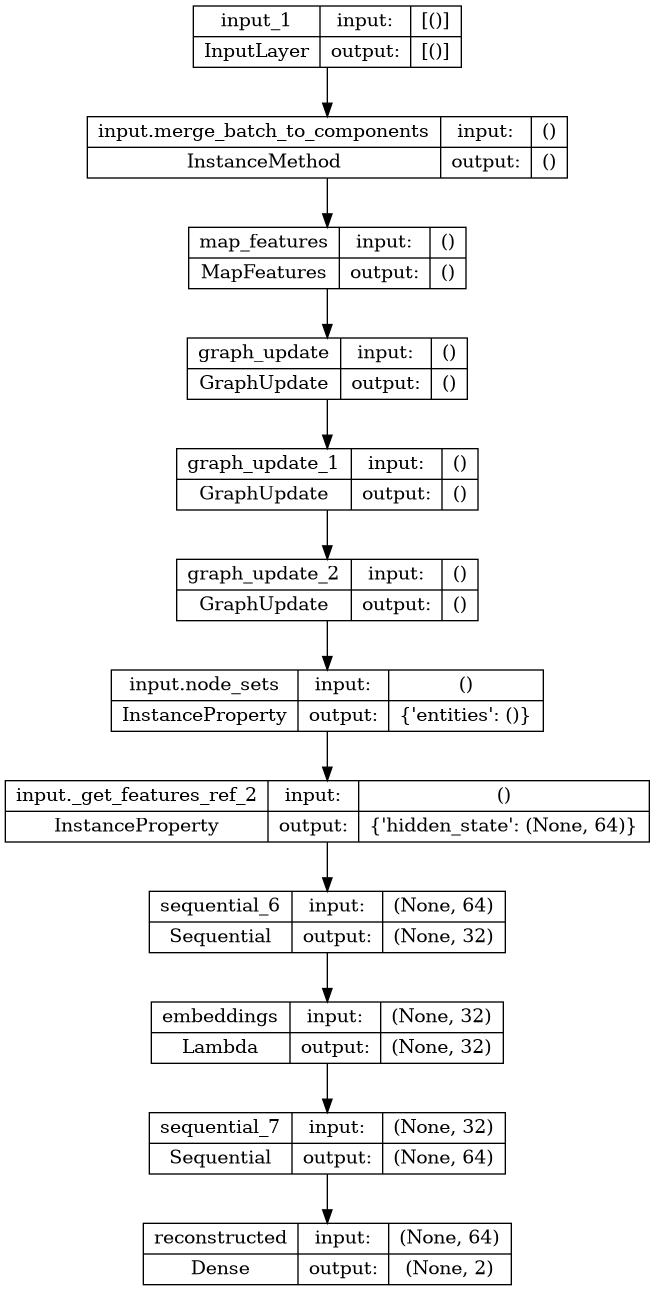

In [18]:
tf.keras.utils.plot_model(gnn_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [18]:
def train_model_standalone(model: tf.keras.Model, 
                          graph_tensor: tfgnn.GraphTensor,
                          output_dim: int = 32,
                          epochs: int = 50) :
    """Standalone training function for direct use in notebooks."""
    logger.info(f"Training GNN model for {epochs} epochs...")
    
    # Get node features for reconstruction target
    target_features = graph_tensor.node_sets['entities']['features']
    num_nodes = tf.shape(target_features)[0]
    dummy_embeddings = tf.zeros((num_nodes, output_dim))
    
    # Create a dataset from the single graph
    # The key is to create a dataset that yields (graph, targets) pairs
    def data_generator():
        yield (graph_tensor, {
            'embeddings': dummy_embeddings,
            'reconstructed': target_features
        })
    
    # Create dataset with proper output signature
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            graph_tensor.spec,
            {
                'embeddings': tf.TensorSpec(shape=(None, output_dim), dtype=tf.float32),
                'reconstructed': tf.TensorSpec(shape=(None, target_features.shape[1]), dtype=tf.float32)
            }
        )
    )
    
    # Batch the dataset (batch size = 1 for single graph)
    dataset = dataset.batch(1)
    
    # Repeat for multiple epochs (model.fit will handle epochs, but this ensures data availability)
    dataset = dataset.repeat()
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'embeddings': tf.keras.losses.MeanSquaredError(),
            'reconstructed': tf.keras.losses.MeanSquaredError()
        },
        loss_weights={'embeddings': 0.1, 'reconstructed': 0.9}
    )
    
    # Train using model.fit
    history = model.fit(
        dataset,
        steps_per_epoch=1,  # One step per epoch since we have one graph
        epochs=epochs,
        verbose=1
    )
    
    return history.history

In [19]:
# Train model
history = train_model_standalone(gnn_model, graph_tensor, epochs=50)

INFO:__main__:Training GNN model for 50 epochs...


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4216 - reconstructed_loss: 12651589600804864.0000
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4225 - reconstructed_loss: 12651589600804864.0000
Epoch 3/50
1/1 [==============================] - 0s 18ms/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4255 - reconstructed_loss: 12651589600804864.0000
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4208 - reconstructed_loss: 12651589600804864.0000
Epoch 5/50
1/1 [==============================] - 0s 18ms/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4294 - reconstructed_loss: 12651589600804864.0000
Epoch 6/50
1/1 [==============================] - 0s 15ms/step - loss: 11386430748098560.0000 - embeddings_loss: 1.4322 - reconstructed_loss: 12651589600804864.0000
Epoch 7/50
1

In [20]:
gnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents (InstanceMethod)                                          
                                                                 
 map_features (MapFeatures)  ()                        512       
                                                                 
 graph_update (GraphUpdate)  ()                        20608     
                                                                 
 graph_update_1 (GraphUpdat  ()                        20608     
 e)                                                              
                                                                 
 graph_update_2 (GraphUpdat  ()                        20608 